## Discrete-Variable Methods

In discrete-variable methods, we are concerned with finding approximations to the solutions, but only at a discrete set of points in the domain.  These points may be predetermined before solving, or we could generate them dynamically as part of the integration, to better suit the properties of the functions involved.  This is specially useful when the solutions present singularities, for example.  Once a discrete set of points are generated, we may of course compute a nice analytic approximation to the solutions, by a simple process of interpolation.

We have two schema for discrete-variable methods:

* *One-step methods*: The value of the solution at one point is computed solely from information on the previous point.  Classical exponents of this scheme are for instance *Euler's method*, *improved Euler's method*, any *second-order two-stage method*, or any *Runge-Kutta method*.
* *Multistep methods*: The value of the solution at one point depends on knowledge of several previous points.  The best known algorithms in this category are the *Adams-Bashford method*, the *Adams-Moulton method*, any *backward-difference method*, or any *predictor-corrector method*.

In the module `scipy.integrate` we have the common interface class `ode`, that will perform an approximation to the solution of equations/systems with a chosen numerical method.   The way to work with this class is very different than what we are used, and deserves a careful explanation.  

1. Once a right-hand side of a differential equation/system is produced, say $y'=f(t,y)$, the process starts by creating an instance of a solver.  We do so by issuing `ode(f)`.   If we have a description of the Jacobian of the right-hand side with respect to the $y$ variables, we may include it in the creation of the solver: `ode(f, jac)`.

2. If extra parameters need to be fed to either the function $f$ or its Jacobian, we do so with the attributes `.set_f_params(*args)` or `.set_jac_params(*args)`, respectively.

3. The initial values to the problem are indicated with the attribute `.set_initial_value(y[, t])`.

4. It is time to chose a numerical scheme.  We do so by setting the attribute `.set_integrator(name, **params)`.  If necessary, we may provide further information to the chosen method, by using the optional parameter.

5. It is time to compute the actual solution of the initial value problem.  We usually accomplish this by playing with several attributes within a loop:  

    * `.integrate(t[, step, relax])` will compute the value of the solution $y(t)$ at the provided time $t$.
    * Retrieval of the last step in the computations can always be obtained with `r.t` (for the time variable) and `r.y` (for the solution)
    * To check for success of computation, we have the attribute `.successful()`.  
    * One integration method accepts a flag function `solout_func(t, y)`, that gets called after each successful step.  This is accomplished with the attribute `.set_solout(solout_func)`, 


### One-step methods

The only one-step methods coded in the `scipy` stack are two implementations of Runge-Kutta, designed by Dormand and Prince, and coded by Hairer and Wanner for the module `scipy.integrate`.

* Explicit Runge-Kutta of order (4)5.  We access it with `method='dopri5'`
* Explicit Runge-Kutta of order 8(5,3).  We call it with `method='dop853'`

Let us run through our examples.  With the first one, we will solve the differential equation by issuing `dopri5`, on a set of 10 nodes given by zeros of the Chebyshev polynomial in the interval $[0,1]$.

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.special import t_roots

%matplotlib inline 

def F(t, y): return y

solver = ode(F) # solver created

In [2]:
solver.set_initial_value(1.0, 0.0) # y(0) = 1

In [3]:
solver.set_integrator('dopri5')

In [4]:
solver.t, solver.y

(0.0, array([ 1.]))

In [5]:
nodes = t_roots(10)[0]
nodes = (nodes + 1.0) * 0.5

for k in range(10):
    if solver.successful():
        t = nodes[k]
        solver.integrate(t)
        print "{0}, {1}, {2}".format(t, solver.y[0], np.exp(t))

0.00615582970243, 1.00617481576, 1.00617481576
0.0544967379058, 1.05600903161, 1.05600903161
0.146446609407, 1.15771311835, 1.15771311818
0.27300475013, 1.31390648743, 1.31390648604
0.42178276748, 1.52467728436, 1.52467727922
0.57821723252, 1.78285718759, 1.78285717608
0.72699524987, 2.06885488518, 2.06885486703
0.853553390593, 2.34797534217, 2.34797531943
0.945503262094, 2.57410852921, 2.5741085039
0.993844170298, 2.7015999731, 2.70159994653


> It is possible to fine-tune the algorithm by providing different tolerances, restriction of number of steps, and other stabilizing constants.  For a detailed desription of the different parameters, refer docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html, or simply request the manual page from within your `ipython` session with `help(ode)`.  

In the example of the Bernoulli equation, we will gather again roots of a Chebyshev polynomial as nodes, but this time we will collect the solutions and construct a piecewise polynomial interpolation with them, to compare the results with the true solution visually.  In this case we employ Runge-Kutta of order 8(5,3).

In [6]:
def bernoulli(t, y): return 3*y**(0.75) - 6.0 * y/t
def G(t): return (3.0*t**(2.5) + 7.0)**4.0 / (10000.0*t**6.0)

T = np.linspace(1, 2, 1024)

solver = ode(bernoulli)
solver.set_initial_value(1.0, 1.0)
solver.set_integrator('dop853')

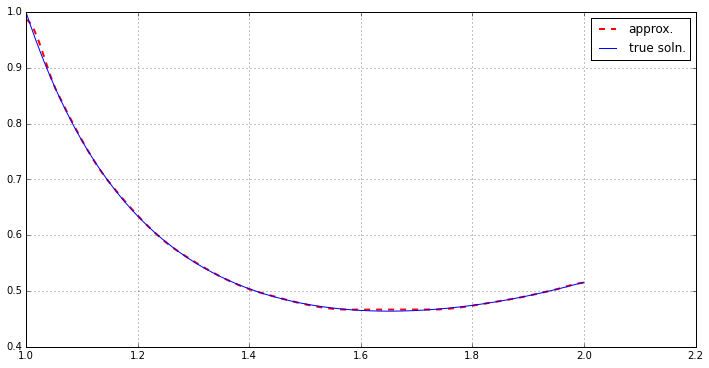

In [7]:
nodes = t_roots(10)[0]
nodes = 1.5 + 0.5 * nodes
solution = []

for k in range(10):
    if solver.successful():
        solver.integrate(nodes[k])
        solution += [solver.y[0]]

from scipy.interpolate import PchipInterpolator

interpolant = PchipInterpolator(nodes, solution)

plt.figure(figsize=(12,6))
plt.plot(T, interpolant(T), 'r--', linewidth=2.0, label='approx.')
plt.plot(T, G(T), 'b-', label='true soln.')
plt.grid()
plt.legend()
plt.show()

The Lotka-Volterra system gets solved in the same fashion.  In the following example we will choose a set of equally spaced nodes in one cycle: the interval from $0$ to $2\pi/\sqrt{1.5}$ (approximately `5.13`)

In [8]:
def volterra(t, y): return [y[0]  - 0.1*y[0]*y[1], 0.075*y[0]*y[1] - 1.5*y[1]]

solver = ode(volterra)
solver.set_initial_value([10.0, 5.0], 0.0)
solver.set_integrator('dop853')

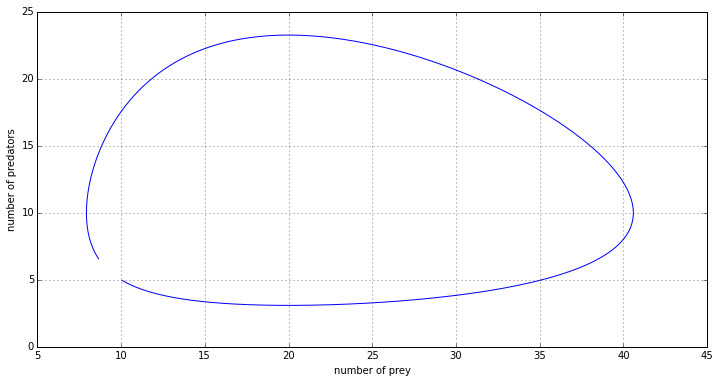

In [9]:
prey = []
predator = []

while (solver.t < 5.13 and solver.successful()):
    solver.integrate(solver.t + 0.01)
    prey += [solver.y[0]]
    predator += [solver.y[1]]

plt.figure(figsize=(12,6))
plt.plot(prey, predator)
plt.grid()
plt.xlabel('number of prey')
plt.ylabel('number of predators')
plt.show()

### Two-step methods

We have two different choices here: an Adams-Moulton method (suitable for non-stiff equations), and a backward-difference method (designed for stiff equations).  For each of these two numerical methods, we have two different implementations, depending on the background `Fortran` routine used to compute the solutions.  The options are as follows:

* `*VODE`:  In the `Fortran` library `ODE` from `netlib`, we have the routines `VODE` and `ZVODE` (for real and complex-valued solution of initial value problems, respectively).  To access the numerical method of Adams-Moulton for a real-valued problem, for example, we issue the attribute `.set_integrator('vode', method='adams'`).  To access backward-differences, we issue `.set_integrator('vode', method='BDF'`)
* `LSODA`: This other implementation wraps different routines from the `Fortran` library `ODEPACK`.  The calls are exactly as in the previous case, substituting `'vode'` or `'zvode'` with `'lsoda'` instead. 


> For more information about the `netlib` libraries `ODE` and `ODEPACK`, refer to +www.metlib.org/ode+ and www.netlib.org/odepack, respectively.  

These numerical methods are designed for large problems.  For smaller tasks (non-stiff one-dimensional equations with small set of nodes), Runge-Kutta should be used instead.  The second example illustrates this point: We apply `BDF` from `VODE`, and compare the solutions obtained with both Runge-Kutta from before, and the actual solution.  Note how `dop853` outperforms `BDF` in this simple case.

In [10]:
solver = ode(bernoulli)
solver.set_initial_value(1.0, 1.0)
solver.set_integrator('vode', method='BDF')

In [11]:
nodes = t_roots(10)[0]
nodes = 1.5 + 0.5 * nodes
solution2 = []

for k in range(10):
    if solver.successful():
        solver.integrate(nodes[k])
        solution2 += [solver.y[0]]

In [12]:
nodes

array([ 1.00615583,  1.05449674,  1.14644661,  1.27300475,  1.42178277,
        1.57821723,  1.72699525,  1.85355339,  1.94550326,  1.99384417])

In [13]:
for k in range(10):
    true_sol = G(nodes[k])
    dop853_sol = solution[k]
    vode_sol = solution2[k]
    print "{0}, {1}, {2}".format(true_sol, dop853_sol, vode_sol)

0.981854827818, 0.981854827818, 0.981855789349
0.859270248468, 0.859270248468, 0.859270080689
0.698456572663, 0.698456572663, 0.698458875953
0.570963875566, 0.570963875559, 0.57096210196
0.49654019444, 0.496540194433, 0.496537599383
0.466684337536, 0.466684337531, 0.466681706374
0.466700776675, 0.46670077667, 0.466699552511
0.482536531899, 0.482536531895, 0.482537207918
0.501698475572, 0.501698475568, 0.501699366611
0.514159743133, 0.514159743128, 0.514160809167


To finish this chapter, we use `LSODA` on our Lotka-Volterra system, taking advantage of the Jacobian.


In [14]:
def jacF(t, y):
    output = np.zeros((2,2))
    output[0,0] = 1.0 - 0.1*y[1]
    output[0,1] = -0.1*y[0]
    output[1,0] = 0.075*y[1]
    output[1,1] = 0.075*y[0] - 1.5
    return output

solver = ode(volterra, jacF)
solver.set_initial_value([10.0, 5.0], 0.0)
solver.set_integrator('lsoda', method='adams', with_jacobian=True)

prey2 = []
predator2  = []

while (solver.t < 5.13 and solver.successful()):
    solver.integrate(solver.t + 0.01)
    prey2 += [solver.y[0]]
    predator2 += [solver.y[1]]